In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Logistic Regression (MNIST)

The wikipedia entry for MNIST is shown below, it is a classic dataset for machine learning. In this case we will investigate the digits classification problem with and without noise and using dimensional reduction with PCA and different numbers of PCs as features. It has many features and many samples (784, 60000) making it computationally intensive in some instances 

Additionally, human text recognition is a real problem that has real applications in some areas as mentioned below:

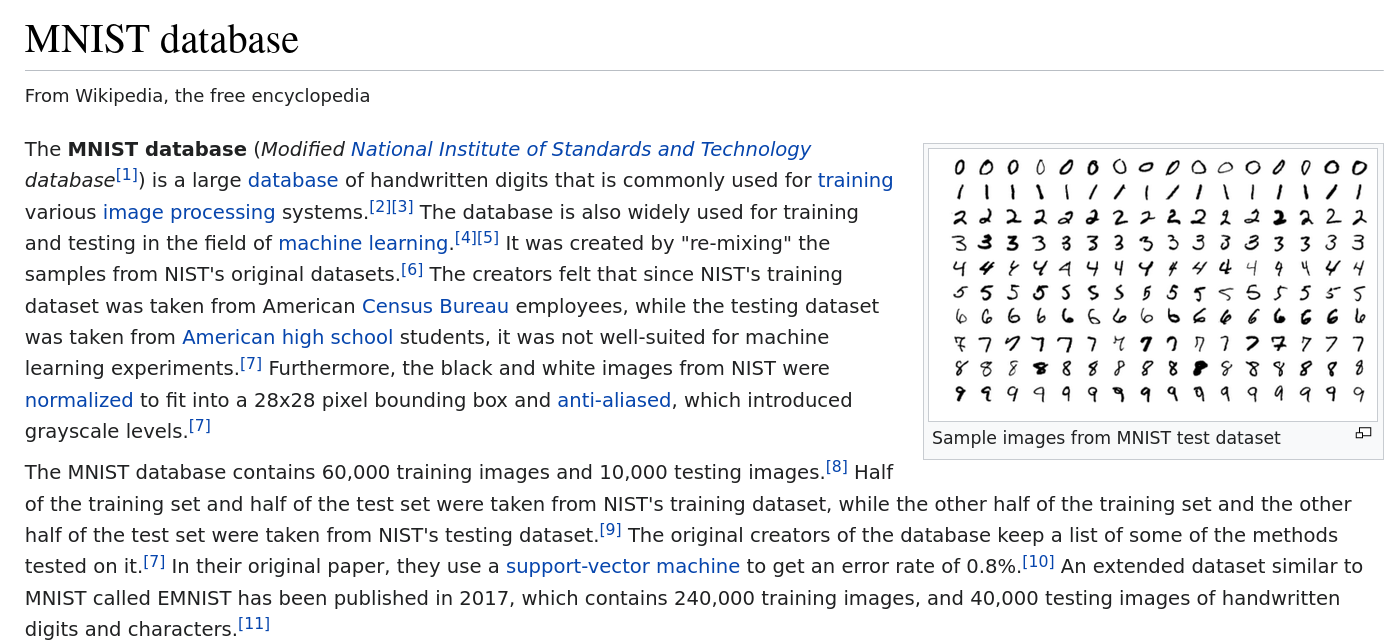

Original Question:

#### 1) Choose a Logistic regression model for a multiclass classification using MNIST data. 

- a)    Do not use PCA. To make images noisy, use different c_noise. Choose a set n_noise = [0, 0.25, 0.5, 1, 1.5, 2, 3, 4.5, 10, 20, 30, 40, 50]. Train the model for each n_noise. Find corresponding accuracy (use, for example, metrics.accuracy_score(pred_va, tar_va)). Plot:  accouracy  vs. n_noise. 

- b)    Do the same step above; however, use a fixed PCA (n_component=100) this time. Plot accuracy vs. n_noise on the same plot.

- c)    Do the same above with PCA (n_component=20).

- d)    Compare three curves and discuss/explain what you see in the plot.

## Load data and Initialize functions 

### Downloading the Data (MNIST)

Initialize my packages as well

In [2]:
import numpy as np
from joblib import parallel_backend
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection as md
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
import time

2022-02-16 18:27:06.167519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Define a function to add noise to the MNIST data

Then I can just call it a bunch of times in a loop

In [3]:
# Load the mnist data
(inp_tr, tar_tr), (inp_va, tar_va) = mnist.load_data()

# Define a function to add noise
def add_noise_to_MNIST(inp_tr, inp_va, c_noise):
    '''
    Add noise to MNIST data
    -----------------------
    
    Inputs
    ------
    inp_tr: numpy arrays
        input and target arrays for training
    inp_va: numpy arrays
        input and target arrays for validation
    c_noise: float
        The maximum of the random noise
    Returns
    -------
    inp_tr, inp_va: numpy arrrays with noise
    
    '''
    
    # So I can specify the amount of the dataset to use and don't assume
    # 60,000 samples
    tr_x = inp_tr.shape[0]
    va_x = inp_va.shape[0]
    
    # Just reshape and normalize if zero
    if c_noise == 0:
        
        return np.reshape(inp_tr, (-1, 784)) / 255., np.reshape(inp_va, (-1, 784)) / 255.
    
    # Make some arrays of Noise
    noise_tr=np.random.rand(tr_x,784)*c_noise
    noise_va=np.random.rand(va_x,784)*c_noise

    # Then normalize by 255
    inp_tr = np.reshape(inp_tr, (-1, 784)) / 255.
    inp_va = np.reshape(inp_va, (-1, 784)) / 255.
    
    # Return the noisy data renormalized
    return (inp_tr+noise_tr)/(1+c_noise), (inp_va+noise_va)/(1+c_noise)

#### Check that the function does what I want by visualizing a few samples

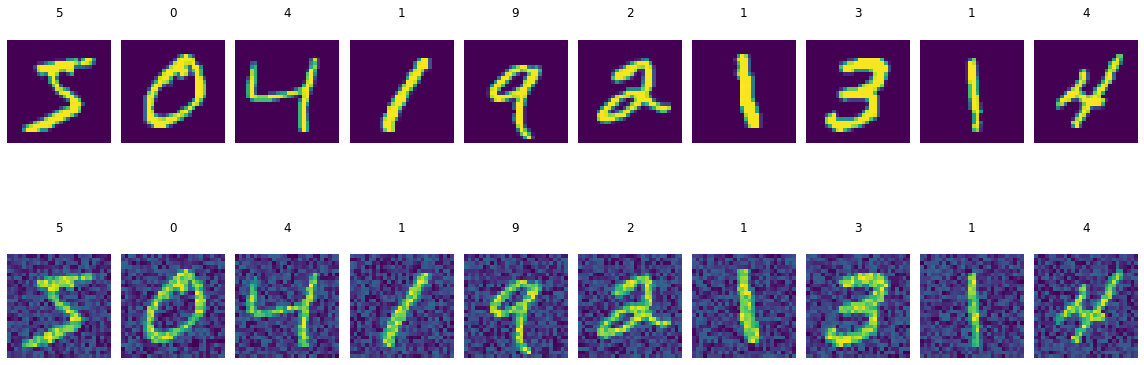

In [4]:
n1 = 0
n2 = 10

# Add some Noise
inp_tr_noise, inp_va_noise = add_noise_to_MNIST(inp_tr, inp_va, 0.5)
# Plot the graph before and after
fig = plt.figure( figsize=(16,7) )
for k1 in range(n1,n2):
    ax = fig.add_subplot(2,10,k1+1, title=str(int(tar_tr[k1])))
    ax.matshow(inp_tr[k1].reshape((28,28)).astype(float),cmap='viridis')
    ax.axis('off')
    
    ax = fig.add_subplot(2,10,k1+11, title=str(int(tar_tr[k1])))
    ax.matshow(inp_tr_noise[k1].reshape((28,28)).astype(float),cmap='viridis')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Looks like it is doing what I want. The data has salt and pepper noise

### Define a function that returns the accuracy

This will streamline all of the trials as a one liner in the for loop

In [5]:
def return_classification_accuracy(inp_tr, tar_tr, inp_va, tar_va, c_noise=0 , PCA_comp = 0,
                                   model=LogisticRegression, **kwargs):
    '''
    Return the classification accuracy for a given noise
    -----------------
    
    Inputs
    ------
    inp_tr, tar_tr: numpy arrays
        input and target arrays for training
    inp_va, tar_va: numpy arrays
        input and target arrays for validation
    c_noise: float
        The noise relative to the normalized value of the
        data, 0 for no noise
    PCA_comp: int
        number of PCs to compress the data to 0 for no
        PCA
    model: sklearn model object
        model to train
    ** kwargs: keyword arguments to pass to the model
    
    Returns
    -------
    training_score: float
        model performance on training data
    validation_score: float
        model performance on validation data
    time_taken: float
        time taken to train
    
    '''
    
    # I'll use all of my cores because this can be slow
    with parallel_backend('threading', n_jobs=8):
        
        # Add noise
        # Use the function defined above
        inp_tr, inp_va = add_noise_to_MNIST(inp_tr, inp_va, c_noise)
        
        # Initialize and transform data using PCA
        # If there is a number of components to use then fit to the
        # number of components
        if PCA_comp > 0:
            pca = PCA(n_components=PCA_comp)
            pca.fit(inp_tr)
            inp_tr = pca.transform(inp_tr)
            inp_va = pca.transform(inp_va)
        
        # Print for debugging
        print(f'Noise is {c_noise}, number of PCs is {PCA_comp}')
        print(f'Shape of the training, validation data {inp_tr.shape, inp_va.shape}')
        # Initialize the model
        model_instance = model(**kwargs)
        
        # Look at the time started
        start = time.time()
        
        # Fit the model
        model_instance.fit(inp_tr, tar_tr)
        pred_tr= model_instance.predict(inp_tr)
        pred_va= model_instance.predict(inp_va)
        
        # Look at the time at the end
        end = time.time()
        time_taken = end - start
        print(f'The time taken was {time_taken} seconds\n')
    
    # Return the performance of the model
    return model_instance.score(inp_tr, tar_tr), model_instance.score(inp_va,tar_va), time_taken

## Look at the model performance without PCA

- a)    Do not use PCA. To make images noisy, use different c_noise. Choose a set n_noise = [0, 0.25, 0.5, 1, 1.5, 2, 3, 4.5, 10, 20, 30, 40, 50]. Train the model for each n_noise. Find corresponding accuracy (use, for example, metrics.accuracy_score(pred_va, tar_va)). Plot:  accouracy  vs. n_noise. 


In [6]:
# Initialize the noise
n_noise = [0, 0.25, 0.5, 1, 1.5, 2, 3, 4.5, 10, 20, 30, 40, 50]
n_pca = 0

# Empty lists for plotting
accuracies_tr_no_pca = []
accuracies_va_no_pca = []

n_tr = 60000

for c_noise in n_noise:
    
    # Return the accuracies for each noise
    ac_tr, ac_va, ti_tr = return_classification_accuracy(
        inp_tr[:n_tr], tar_tr[:n_tr], inp_va, tar_va, c_noise, penalty='l2',verbose=0,PCA_comp=n_pca
    )
    accuracies_tr_no_pca.append(ac_tr)
    accuracies_va_no_pca.append(ac_va)

Noise is 0, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 6.4664390087127686 seconds

Noise is 0.25, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 6.085530757904053 seconds

Noise is 0.5, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 6.523011684417725 seconds

Noise is 1, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 6.241712808609009 seconds

Noise is 1.5, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 6.668558597564697 seconds

Noise is 2, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 7.2049853801727295 seconds

Noise is 3, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 7.352776288986206 seconds

Noise is 4.5, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 7.122291326522827 seconds

Noise is 10, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 7.605058193206787 seconds

Noise is 20, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 7.309566497802734 seconds

Noise is 30, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 6.811538934707642 seconds

Noise is 40, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 7.392768621444702 seconds

Noise is 50, number of PCs is 0
Shape of the training, validation data ((60000, 784), (10000, 784))
The time taken was 7.355431079864502 seconds



/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### The model is not converging but still gives dependably good results so I am not too worried about this warning message

## Plot the results

Save the results for later so that I can plot them without re-running the training

In [7]:
np.save('accuracies_tr_no_pca',accuracies_tr_no_pca)
np.save('accuracies_va_no_pca',accuracies_va_no_pca)

Text(0.5, 0, 'log Noise Level')

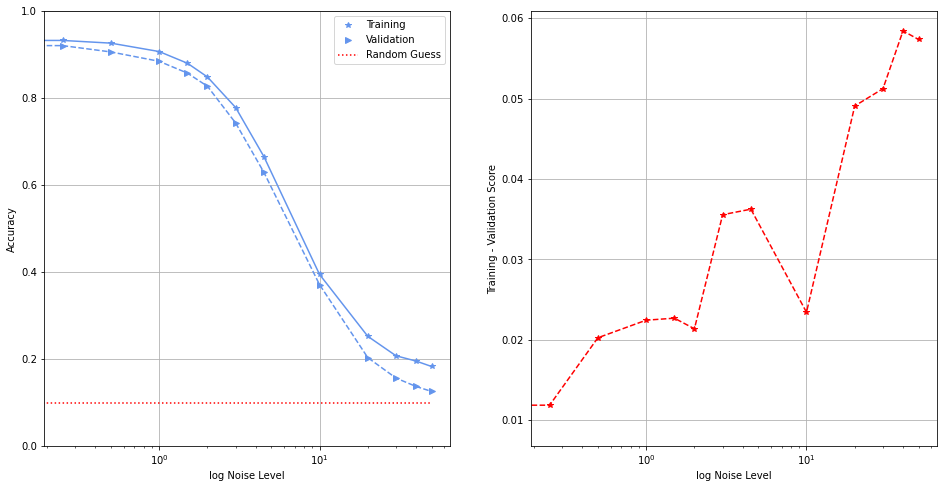

In [8]:
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.semilogx(n_noise,accuracies_tr_no_pca,c='cornflowerblue')
plt.semilogx(n_noise,accuracies_tr_no_pca,'*',c='cornflowerblue',label='Training')
plt.semilogx(n_noise,accuracies_va_no_pca,'--',c='cornflowerblue')
plt.semilogx(n_noise,accuracies_va_no_pca,'>',c='cornflowerblue',label='Validation')
plt.semilogx([0,50],[0.1,0.1],'r:',label='Random Guess')
plt.ylabel('Accuracy')
plt.xlabel('log scaled Noise Level')
plt.ylim([0,1])
plt.legend()
plt.grid('on')
plt.subplot(122)
plt.semilogx(n_noise,np.array(accuracies_tr_no_pca) - accuracies_va_no_pca,'r--')
plt.semilogx(n_noise,np.array(accuracies_tr_no_pca) - accuracies_va_no_pca,'r*')
plt.grid('on')
plt.ylabel('Training - Validation Score')
plt.xlabel('log scaled Noise Level')

In [9]:
print(f'The validation accuracties without PCA were {accuracies_va_no_pca}')
print(f'The training accuracties without PCA were {np.array(accuracies_tr_no_pca).round(4)}')

The validation accuracties without PCA were [0.9258, 0.9207, 0.9061, 0.8846, 0.8575, 0.8272, 0.7426, 0.6292, 0.3712, 0.2032, 0.1562, 0.1369, 0.1255]
The training accuracties without PCA were [0.9351 0.9326 0.9264 0.907  0.8802 0.8486 0.7782 0.6654 0.3946 0.2523
 0.2074 0.1953 0.1829]


#### I plotted the accuracy for the training and validation sets in a log x axis to better visualize the scale of the data. The model performed quite well with an accuracy of ~ 0.935 and 0.9258 without noise (might change, didn't set rng seed). The training accuracy was not marginally different for values up to a noise of 1 but decreased dramatically for values between one and ten. Beyond ten the model plateaued as it approached a validation accuracy of 0.1 which is equivalent to a random guess. 

#### The difference in the training and validation scores increased roughly exponentially with noise although I have no rationale for why a specific exponential relation would exist. Overfitting likely occurs when the data becomes less and less structured and the feature data contains less information to make true classifications, leading the model to train based off of random features in the data and thus not reflect the population.

## Look at the model performance with PCA=100

- b)    Do the same step above; however, use a fixed PCA (n_component=100) this time. Plot accuracy vs. n_noise on the same plot.

<!-- - c)    Do the same above with PCA (n_component=20).

- d)    Compare three curves and discuss/explain what you see in the plot. -->

In [10]:
# Set the variables 
n_pca = 100

# Make empty lists to store data
accuracies_tr_100_pca = []
accuracies_va_100_pca = []

# Run a loop over the noise levels
for c_noise in n_noise:
    
    # Return the classification scores
    ac_tr, ac_va, ti_tr = return_classification_accuracy(
        inp_tr[:n_tr], tar_tr[:n_tr], inp_va, tar_va, c_noise, penalty='l2',verbose=0,PCA_comp=n_pca
    )
    accuracies_tr_100_pca.append(ac_tr)
    accuracies_va_100_pca.append(ac_va)

Noise is 0, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 2.9759726524353027 seconds

Noise is 0.25, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 2.9719693660736084 seconds

Noise is 0.5, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 2.7997772693634033 seconds

Noise is 1, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))
The time taken was 2.537876605987549 seconds

Noise is 1.5, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))
The time taken was 1.8082075119018555 seconds

Noise is 2, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))
The time taken was 1.6810531616210938 seconds

Noise is 3, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))
The time taken was 1.4402368068695068 seconds

Noise is 4.5, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))
The time taken was 1.023841381072998 seconds

Noise is 10, number of PCs is 100
Shape of the training, validation data ((60000, 100), (10000, 100))
The time taken was 0.701016902923584 seconds

Noise is 20, number of PCs is 100
Shape of the training, valida

#### The model was much quicker with only 100 PCs and became quicker with added noise. I think the model converged faster when the data was noisy because the loss function became flatter.

## Plot the results

Save the results for later so that I can plot them without re-running the training

In [11]:
np.save('accuracies_tr_100_pca',accuracies_tr_100_pca)
np.save('accuracies_va_100_pca',accuracies_va_100_pca)

Text(0.5, 0, 'log Noise Level')

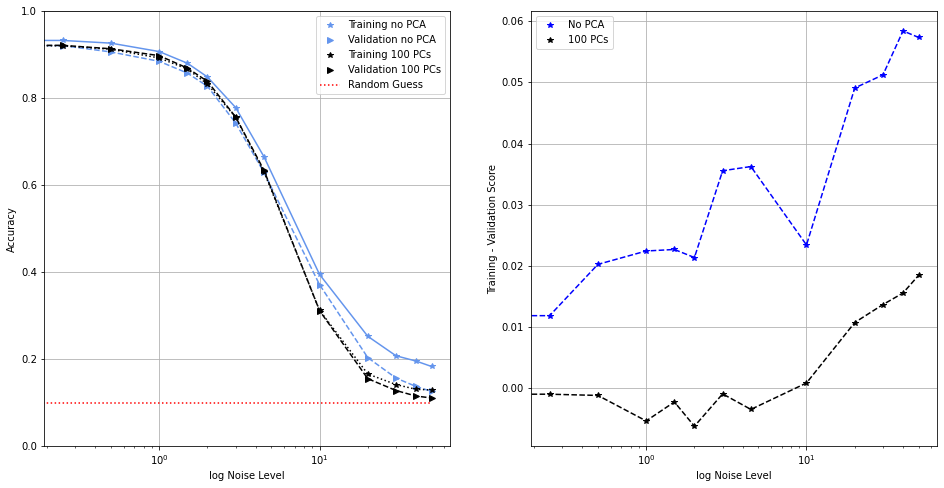

In [12]:
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.semilogx(n_noise,accuracies_tr_no_pca,c='cornflowerblue')
plt.semilogx(n_noise,accuracies_tr_no_pca,'*',c='cornflowerblue',label='Training no PCA')
plt.semilogx(n_noise,accuracies_va_no_pca,'--',c='cornflowerblue')
plt.semilogx(n_noise,accuracies_va_no_pca,'>',c='cornflowerblue',label='Validation no PCA')
plt.semilogx(n_noise,accuracies_tr_100_pca,':',c='k')
plt.semilogx(n_noise,accuracies_tr_100_pca,'*',c='k',label='Training 100 PCs')
plt.semilogx(n_noise,accuracies_va_100_pca,'--',c='k')
plt.semilogx(n_noise,accuracies_va_100_pca,'>',c='k',label='Validation 100 PCs')
plt.semilogx([0,50],[0.1,0.1],'r:',label='Random Guess')
plt.ylabel('Accuracy')
plt.xlabel('log Noise Level')
plt.ylim([0,1])
plt.legend()
plt.grid('on')
plt.subplot(122)
plt.semilogx(n_noise,np.array(accuracies_tr_no_pca) - accuracies_va_no_pca,'b--')
plt.semilogx(n_noise,np.array(accuracies_tr_no_pca) - accuracies_va_no_pca,'b*',label='No PCA')
plt.semilogx(n_noise,np.array(accuracies_tr_100_pca) - accuracies_va_100_pca,'k--')
plt.semilogx(n_noise,np.array(accuracies_tr_100_pca) - accuracies_va_100_pca,'k*',label='100 PCs')
plt.legend()
plt.grid('on')
plt.ylabel('Training - Validation Score')
plt.xlabel('log Noise Level')

In [13]:
print(f'The validation accuracties with 100 PCs were {accuracies_va_100_pca}')
print(f'The training accuracties with 100 PCs were {np.array(accuracies_tr_100_pca).round(4)}')

The validation accuracties with 100 PCs were [0.921, 0.9213, 0.9134, 0.8976, 0.869, 0.8385, 0.7565, 0.6344, 0.3114, 0.1548, 0.1276, 0.1148, 0.1105]
The training accuracties with 100 PCs were [0.9222 0.9204 0.9122 0.8923 0.8668 0.8323 0.7556 0.631  0.3123 0.1656
 0.1413 0.1304 0.129 ]


#### The validation accuracy was not much different for the low noise data with 100 PCs with accuracy of 0.9209 as compared to 0.9258 for the model without PCA. However, training and validation accuracy were much closer over all cases for the PCA and overfitting did not increase with more noise. Validation accuracy was considerably worse overall for more noise though with noise levels over 10 seeing much worse performance.

#### It seems that PCA is good at suppressing overfitting in Logistic Regression but worse for performance

## Look at the model performance with PCA=20

<!-- - b)    Do the same step above; however, use a fixed PCA (n_component=100) this time. Plot accuracy vs. n_noise on the same plot. -->

- c)    Do the same above with PCA (n_component=20).

<!-- - d)    Compare three curves and discuss/explain what you see in the plot. -->

In [14]:
n_pca = 20

accuracies_tr_20_pca = []
accuracies_va_20_pca = []

for c_noise in n_noise:
    
    # Return the accuracy
    ac_tr, ac_va, ti_tr = return_classification_accuracy(
        inp_tr[:n_tr], tar_tr[:n_tr], inp_va, tar_va, c_noise, penalty='l2',verbose=0,PCA_comp=n_pca
    )
    accuracies_tr_20_pca.append(ac_tr)
    accuracies_va_20_pca.append(ac_va)

Noise is 0, number of PCs is 20
Shape of the training, validation data ((60000, 20), (10000, 20))


/home/xcite/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The time taken was 2.4542644023895264 seconds

Noise is 0.25, number of PCs is 20
Shape of the training, validation data ((60000, 20), (10000, 20))
The time taken was 2.069384813308716 seconds

Noise is 0.5, number of PCs is 20
Shape of the training, validation data ((60000, 20), (10000, 20))
The time taken was 1.889333724975586 seconds

Noise is 1, number of PCs is 20
Shape of the training, validation data ((60000, 20), (10000, 20))
The time taken was 1.799706220626831 seconds

Noise is 1.5, number of PCs is 20
Shape of the training, validation data ((60000, 20), (10000, 20))
The time taken was 1.441859245300293 seconds

Noise is 2, number of PCs is 20
Shape of the training, validation data ((60000, 20), (10000, 20))
The time taken was 1.5416791439056396 seconds

Noise is 3, number of PCs is 20
Shape of the training, validation data ((60000, 20), (10000, 20))
The time taken was 1.2603540420532227 seconds

Noise is 4.5, number of PCs is 20
Shape of the training, validation data ((60000

#### The model was much quicker with only 20 PCs and became quicker with added noise. I think the model converged faster when the data was noisy because the loss function became flatter. Additionally with less features to fit weights to the model is faster than for the case with 784 features.

## Plot the results

Save the results for later so that I can plot them without re-running the training

In [15]:
np.save('accuracies_tr_20_pca',accuracies_tr_20_pca)
np.save('accuracies_va_20_pca',accuracies_va_20_pca)

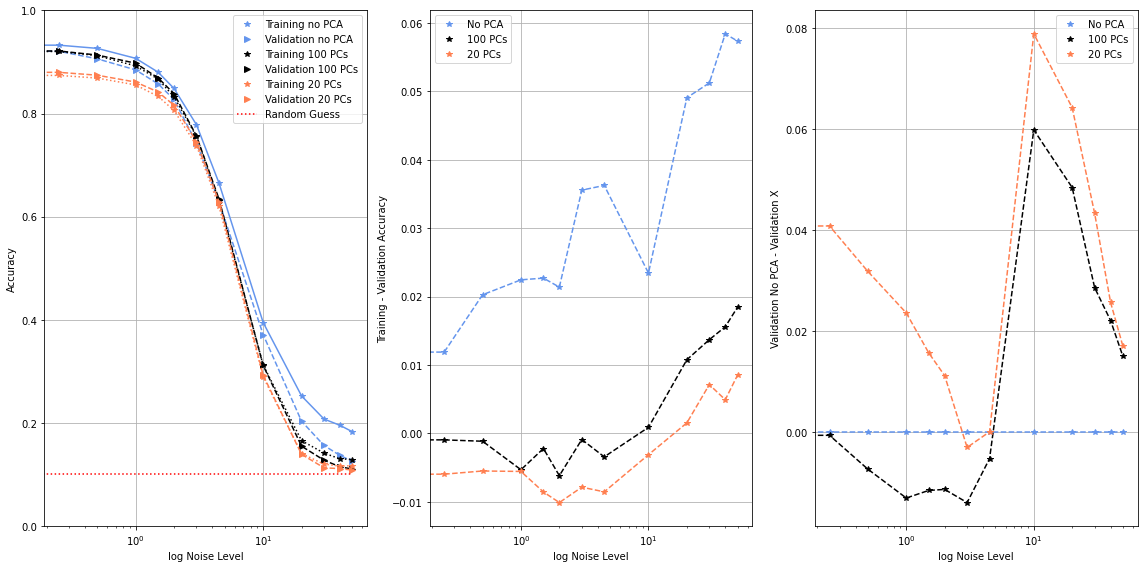

In [16]:
plt.figure(figsize=[16,8])
plt.subplot(131)
plt.semilogx(n_noise,accuracies_tr_no_pca,c='cornflowerblue')
plt.semilogx(n_noise,accuracies_tr_no_pca,'*',label='Training no PCA',c='cornflowerblue')
plt.semilogx(n_noise,accuracies_va_no_pca,'--',c='cornflowerblue')
plt.semilogx(n_noise,accuracies_va_no_pca,'>',label='Validation no PCA',c='cornflowerblue')
plt.semilogx(n_noise,accuracies_tr_100_pca,':',c='k')
plt.semilogx(n_noise,accuracies_tr_100_pca,'*',c='k',label='Training 100 PCs')
plt.semilogx(n_noise,accuracies_va_100_pca,'--',c='k')
plt.semilogx(n_noise,accuracies_va_100_pca,'>',c='k',label='Validation 100 PCs')
plt.semilogx(n_noise,accuracies_tr_20_pca,':',c='coral')
plt.semilogx(n_noise,accuracies_tr_20_pca,'*',c='coral',label='Training 20 PCs')
plt.semilogx(n_noise,accuracies_va_20_pca,'--',c='coral')
plt.semilogx(n_noise,accuracies_va_20_pca,'>',c='coral',label='Validation 20 PCs')
plt.semilogx([0,50],[0.1,0.1],'r:',label='Random Guess')
plt.ylabel('Accuracy')
plt.xlabel('log Noise Level')
plt.ylim([0,1])
plt.legend()
plt.grid('on')
plt.subplot(132)
plt.semilogx(n_noise,np.array(accuracies_tr_no_pca) - accuracies_va_no_pca,'--',c='cornflowerblue')
plt.semilogx(n_noise,np.array(accuracies_tr_no_pca) - accuracies_va_no_pca,'*',label='No PCA',c='cornflowerblue')
plt.semilogx(n_noise,np.array(accuracies_tr_100_pca) - accuracies_va_100_pca,'k--')
plt.semilogx(n_noise,np.array(accuracies_tr_100_pca) - accuracies_va_100_pca,'k*',label='100 PCs')
plt.semilogx(n_noise,np.array(accuracies_tr_20_pca) - accuracies_va_20_pca,'--',c='coral')
plt.semilogx(n_noise,np.array(accuracies_tr_20_pca) - accuracies_va_20_pca,'*',c='coral',label='20 PCs')
plt.legend()
plt.grid('on')
plt.ylabel('Training - Validation Accuracy')
plt.xlabel('log Noise Level')
plt.subplot(133)
plt.semilogx(n_noise,np.array(accuracies_va_no_pca) - accuracies_va_no_pca,'--',c='cornflowerblue')
plt.semilogx(n_noise,np.array(accuracies_va_no_pca) - accuracies_va_no_pca,'*',label='No PCA',c='cornflowerblue')
plt.semilogx(n_noise,np.array(accuracies_va_no_pca) - accuracies_va_100_pca,'k--')
plt.semilogx(n_noise,np.array(accuracies_va_no_pca) - accuracies_va_100_pca,'k*',label='100 PCs')
plt.semilogx(n_noise,np.array(accuracies_va_no_pca) - accuracies_va_20_pca,'--',c='coral')
plt.semilogx(n_noise,np.array(accuracies_va_no_pca) - accuracies_va_20_pca,'*',c='coral',label='20 PCs')
plt.grid('on')
plt.ylabel('Validation No PCA - Validation X')
plt.xlabel('log Noise Level')
plt.legend()
plt.tight_layout()

In [17]:
print(f'The validation accuracties with 20 PCs were {accuracies_va_20_pca}')
print(f'The training accuracties with 20 PCs were {np.array(accuracies_tr_20_pca).round(4)}')

The validation accuracties with 20 PCs were [0.8806, 0.8799, 0.8743, 0.861, 0.8418, 0.816, 0.7456, 0.6291, 0.2924, 0.139, 0.1129, 0.1112, 0.1085]
The training accuracties with 20 PCs were [0.8749 0.8739 0.8688 0.8554 0.8332 0.8059 0.7377 0.6206 0.2893 0.1405
 0.12   0.1161 0.117 ]


#### The validation accuracy was considerably worse for the low noise case and 20 PCs with accuracy of 0.8804 as compared to 0.9258 for the model without PCA amounting to a 4.5% difference. However, training and validation accuracy were much closer over all cases for the PCA and overfitting did not increase with more noise (as seen in the middle plot above). Again, validation accuracy was considerably worse for more noise though with noise levels over 10 seeing much worse performance. 

#### Looking at the validation performance (right plot) 20 PCs faired considerably worse for low noise while 100 Pcs was comparable. Validation accuracy was best without PCA for all noise levels over 4.5.

#### It was somewhat expected that validation accuracy would be worse for 20 PCs since 100 PCs contain over 90% of the variance of the MNIST dataset while 20 PCs contains only about 60% of the variance as we saw in class.